In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

from astropy.time import Time

from gPhoton import gFind
from gPhoton import gAperture
from gPhoton import gMap
from gPhoton.gphoton_utils import read_lc
import datetime

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [2]:
file = 'kepler.csv'
# http://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=koi
# confirmed KOIs with Depth > 1000ppm


df = pd.read_csv(file, comment='#')
df.columns

Index([u'rowid', u'kepid', u'kepoi_name', u'kepler_name', u'koi_disposition',
       u'koi_vet_stat', u'koi_vet_date', u'koi_pdisposition', u'koi_score',
       u'koi_fpflag_nt',
       ...
       u'koi_dikco_mdec', u'koi_dikco_mdec_err', u'koi_dikco_msky',
       u'koi_dikco_msky_err', u'koi_dikco_fra', u'koi_dikco_fra_err',
       u'koi_dikco_fdec', u'koi_dikco_fdec_err', u'koi_dikco_fsky',
       u'koi_dikco_fsky_err'],
      dtype='object', length=153)

In [3]:
df.shape

(465, 153)

/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


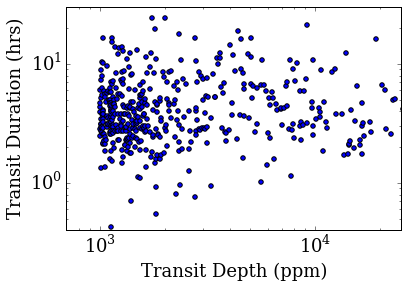

In [4]:
plt.scatter(df[u'koi_depth'], df[u'koi_duration'])
plt.xlim(7e2, 2.5e4)
plt.ylim(4e-1, 3e1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Transit Depth (ppm)')
plt.ylabel('Transit Duration (hrs)')

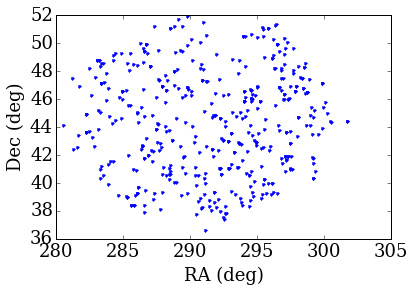

In [5]:
plt.plot(df[u'ra'], df[u'dec'],'.')
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

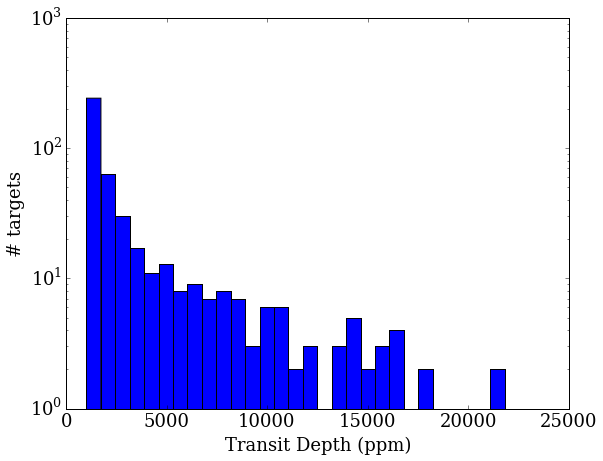

In [6]:
plt.figure(figsize=(9,7))
_ = plt.hist(df[u'koi_depth'][np.isfinite(df[u'koi_depth'])],bins=50)
plt.yscale('log')
plt.xlabel('Transit Depth (ppm)')
plt.ylabel('# targets')
plt.xlim(0,2.5e4)
plt.savefig('depth_hist.png')


In [7]:
# "t_GALEX" = t_UNIX - 315964800.
t0_GALEX = 315964800.

In [8]:
NGalex = np.zeros(len(df[u'ra'])) # number galex observations
ExpGalex = np.zeros(len(df[u'ra'])) # total exposure time
TGalex = np.zeros(len(df[u'ra'])) # total time span

Overlap = np.zeros(len(df[u'ra'])) # does any data overlap w/ kepler?

## Search all planets for overlap

In [9]:
# for i in range(0,len(df[u'ra'])):
#     print(i, df[u'kepid'].values[i])
#     exp_data = gFind(band="NUV", skypos=[df[u'ra'].values[i],df[u'dec'].values[i]], exponly=True)
    
#     if exp_data['NUV']['expt'] > 0:
#         ExpGalex[i] = exp_data['NUV']['expt']
#         NGalex[i] = exp_data['NUV']['t0'].size
#         TGalex[i] = exp_data['NUV']['t0'][-1] - exp_data['NUV']['t0'][0]
            
#         t0 = Time(exp_data['NUV']['t0'] + t0_GALEX, format='unix')
#         t1 = Time(exp_data['NUV']['t1'] + t0_GALEX, format='unix')
#         p0 = np.mod((t0.jd - df[u'koi_time0'].values[i]), df[u'koi_period'].values[i]) / df[u'koi_period'].values[i]
#         p1 = np.mod((t1.jd - df[u'koi_time0'].values[i]), df[u'koi_period'].values[i]) / df[u'koi_period'].values[i]

#         dur = (df[u'koi_duration'].values[i] / 24.) / df[u'koi_period'].values[i]
        
#         # near phase=0
#         if (sum(p0 <= dur/2.) > 0) or (sum(p1 <= dur/2.) > 0):
#             Overlap[i] = 1
        
#         # near phase=1
#         if (sum(p0 >= 1-dur/2.) > 0) or (sum(p1 >= 1-dur/2.) > 0):
#             Overlap[i] = 1
        
#         # t0 before ingress (phase=1) AND t1 after egress (phase=0)
#         if (sum(p1 < p0) > 0):
#             Overlap[i] = 1
        
#         if Overlap[i] > 0:
#             print('OVERLAP!')

In [10]:
# np.save('Overlap.npy', Overlap)

Overlap = np.load('Overlap.npy')

In [11]:
print(sum(Overlap > 0),' systems with overlaps')

(21, ' systems with overlaps')


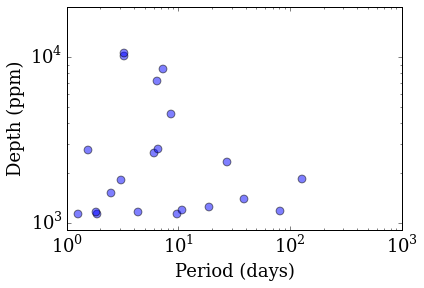

In [12]:
ok = np.where((Overlap > 0))[0]
# targ = np.where((Overlap > 0) & (df[u'koi_depth'] > 1e4) & (df[u'koi_period'] < 10))[0]

plt.scatter(df[u'koi_period'].values[ok], df[u'koi_depth'].values[ok], alpha=0.5, s=60)
# plt.scatter(df[u'koi_period'].values[targ], df[u'koi_depth'].values[targ], alpha=0.5, s=50, color='red')

plt.xlabel('Period (days)')
plt.ylabel('Depth (ppm)')
plt.ylim(9e2,2e4)
plt.xscale('log')
plt.yscale('log')
plt.savefig('transit_overlap1.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

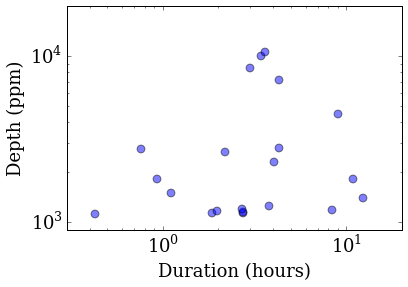

In [13]:
plt.scatter(df[u'koi_duration'].values[ok], df[u'koi_depth'].values[ok], alpha=0.5, s=60)

plt.xlabel('Duration (hours)')
plt.ylabel('Depth (ppm)')
plt.ylim(9e2,2e4)
plt.xlim(3e-1,2e1)
plt.xscale('log')
plt.yscale('log')
plt.savefig('transit_overlap2.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

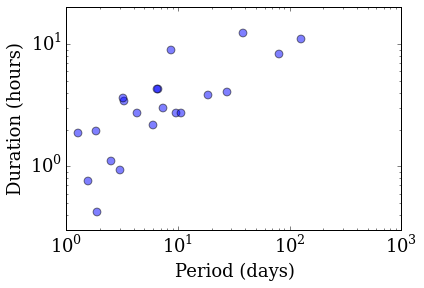

In [14]:
plt.scatter(df[u'koi_period'].values[ok], df[u'koi_duration'].values[ok], alpha=0.5, s=60)

plt.xlabel('Period (days)')
plt.ylabel('Duration (hours)')
plt.ylim(3e-1,2e1)
plt.xscale('log')
plt.yscale('log')
plt.savefig('transit_overlap3.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

## Pull light curves for the systems with transit overlaps

In [23]:
step_size = 120. # the time resolution (sec)

# parameters from tutorial.... maybe not good enough?
img_step_size = 30.
img_size = [0.1, 0.1]
phot_rad = 0.0045
ap_in = 0.0050
ap_out = 0.0060

NUV: 5579.0s (raw) in 5 exposures.
Using v1.28.2 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [292.21906000000001, 44.619160000000001]
 tranges: [930433119.75, 930434218]
 radius:  0.0045
 annulus: [0.005, 0.006]
 stepsz:  120.0
 csvfile: K00961.03_T0_lc.csv
 verbose: 3
NUV: 13478.0s (raw) in 13 exposures.
Using v1.28.2 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [291.80801000000002, 38.622700000000002]
 tranges: [903018649.75, 903020286]
 radius:  0.0045
 annulus: [0.005, 0.006]
 stepsz:  120.0
 csvfile: K02126.01_T0_lc.csv
 verbose: 3
NUV: 5572.0s (raw) in 7 exposures.
Using v1.28.2 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [288.32791000000003, 47.381591999999998]
 tranges: [841590795.75, 841590905]
 radius:  0.0045
 annulus: [0.005, 0.006]
 stepsz:  120.0
 csvfile: K00732.01_T0_lc.csv
 verbose: 3
Using v1.28.2 of gAperture.
Generating a 

/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2809: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.32301327691e-16, top=1.32301327691e-16
  'bottom=%s, top=%s') % (bottom, top))
/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0113886567196, right=0.0113886567196
  'left=%s, right=%s') % (left, right))
/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2809: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=4.00857210054e-15, top=4.00857210054e-15
  'bottom=%s, top=%s') % (bottom, top))


NUV: 3577.0s (raw) in 7 exposures.
Using v1.28.2 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [281.19472999999999, 47.497131000000003]
 tranges: [992603523.75, 992604353]
 radius:  0.0045
 annulus: [0.005, 0.006]
 stepsz:  120.0
 csvfile: K00104.01_T0_lc.csv
 verbose: 3
NUV: 7356.0s (raw) in 6 exposures.
Using v1.28.2 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [282.25020999999998, 44.921108000000004]
 tranges: [929841103.75, 929842395]
 radius:  0.0045
 annulus: [0.005, 0.006]
 stepsz:  120.0
 csvfile: K02842.03_T0_lc.csv
 verbose: 3
NUV: 13374.0s (raw) in 13 exposures.
Using v1.28.2 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [291.02013999999997, 39.220680000000002]
 tranges: [962282683.75, 962283920]
 radius:  0.0045
 annulus: [0.005, 0.006]
 stepsz:  120.0
 csvfile: K01335.01_T0_lc.csv
 verbose: 3
NUV: 2344.0s (raw) in 4 exposures.
Using 

/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0030442359427, right=0.0030442359427
  'left=%s, right=%s') % (left, right))
/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2809: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=4.84876193361e-16, top=4.84876193361e-16
  'bottom=%s, top=%s') % (bottom, top))


NUV: 7356.0s (raw) in 6 exposures.
Using v1.28.2 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [282.25020999999998, 44.921108000000004]
 tranges: [933496940.75, 933498600]
 radius:  0.0045
 annulus: [0.005, 0.006]
 stepsz:  120.0
 csvfile: K02842.01_T0_lc.csv
 verbose: 3
NUV: 255.0s (raw) in 1 exposures.
Using v1.28.2 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [290.09805, 50.321609000000002]
 tranges: [896322046.75, 896322303]
 radius:  0.0045
 annulus: [0.005, 0.006]
 stepsz:  120.0
 csvfile: K00782.01_T0_lc.csv
 verbose: 3
NUV: 1642.0s (raw) in 1 exposures.
Using v1.28.2 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [292.28732000000002, 43.197280999999997]
 tranges: [962128494.75, 962130138]
 radius:  0.0045
 annulus: [0.005, 0.006]
 stepsz:  120.0
 csvfile: K00680.01_T0_lc.csv
 verbose: 3
NUV: 8121.0s (raw) in 9 exposures.
Using v1.28.2 of g

/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.00535080329934, right=0.00535080329934
  'left=%s, right=%s') % (left, right))


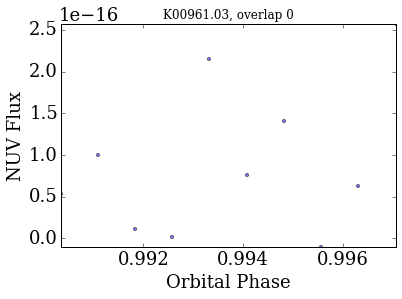

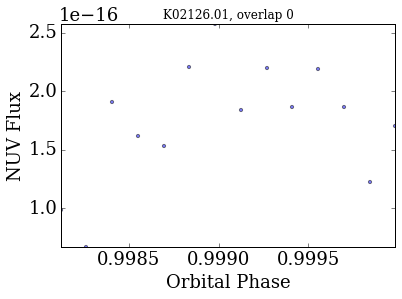

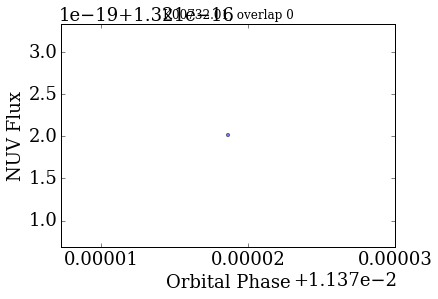

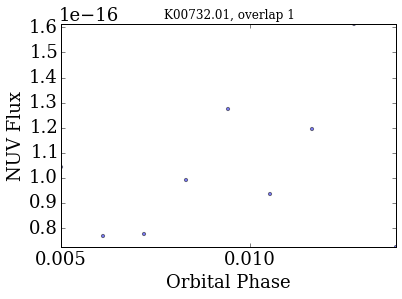

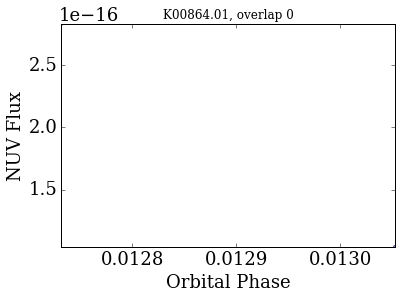

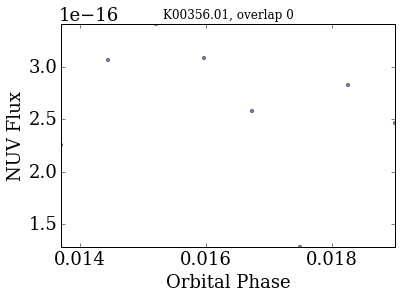

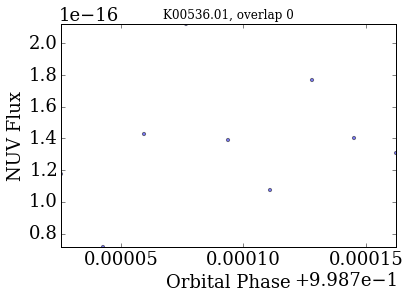

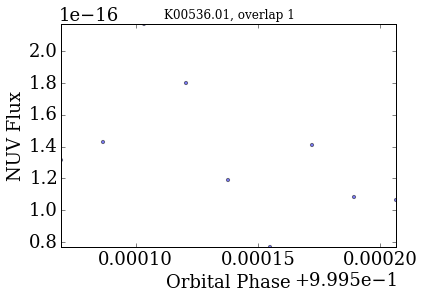

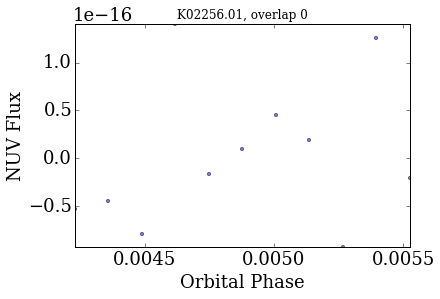

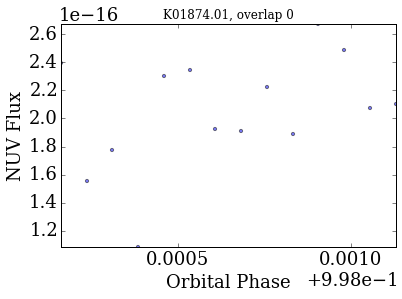

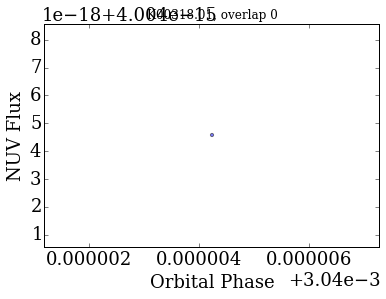

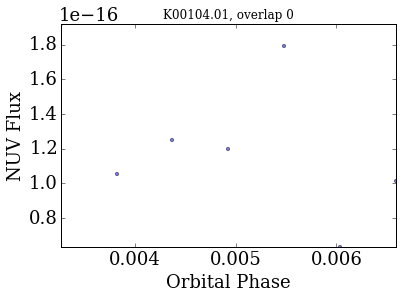

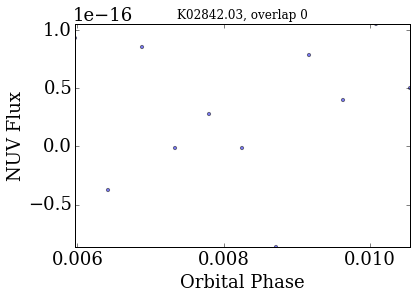

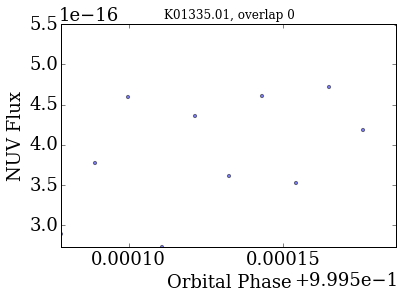

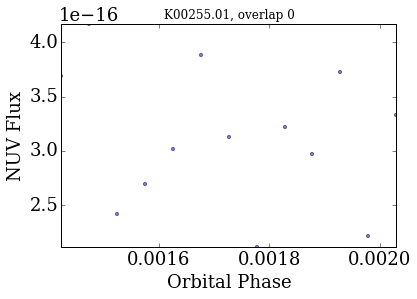

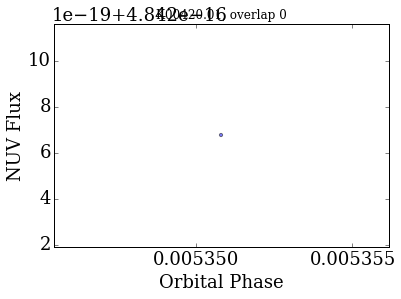

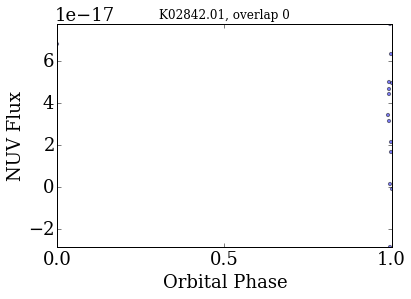

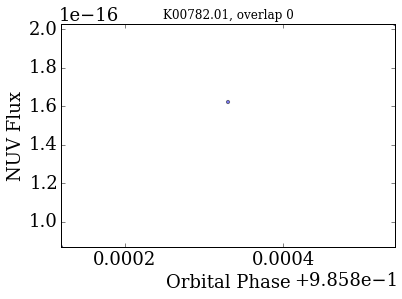

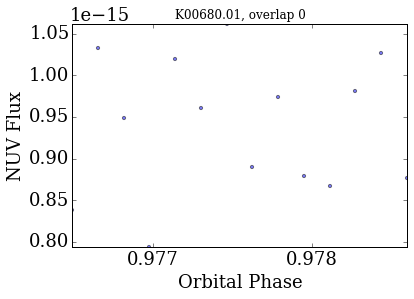

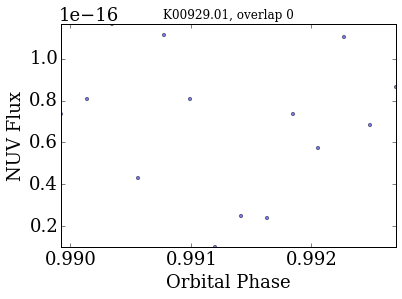

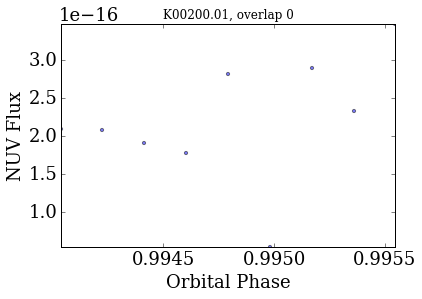

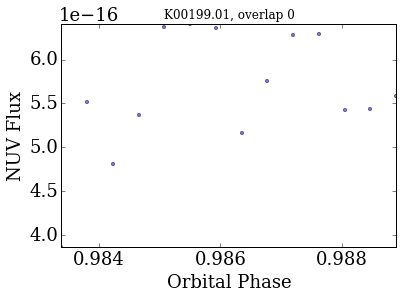

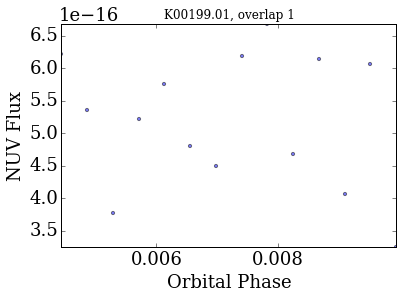

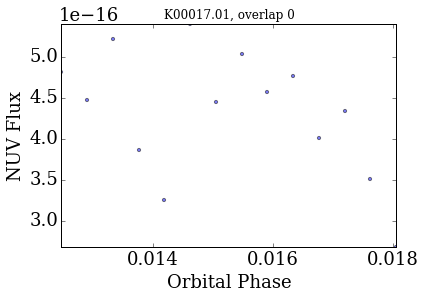

In [25]:

# loop over all stars that have any overlaps (determined above)
for i in range(np.size(ok)):
    # pull the exposure data back in

    exp_data = gFind(band="NUV", skypos=[df[u'ra'].values[ok[i]], df[u'dec'].values[ok[i]]], exponly=True)

    t0 = Time(exp_data['NUV']['t0'] + t0_GALEX, format='unix')
    t1 = Time(exp_data['NUV']['t1'] + t0_GALEX, format='unix')
    p0 = np.mod((t0.jd - df[u'koi_time0'].values[ok[i]]), 
                df[u'koi_period'].values[ok[i]]) / df[u'koi_period'].values[ok[i]]
    p1 = np.mod((t1.jd - df[u'koi_time0'].values[ok[i]]), 
                df[u'koi_period'].values[ok[i]]) / df[u'koi_period'].values[ok[i]]

    dur = (df[u'koi_duration'].values[ok[i]] / 24.) / df[u'koi_period'].values[ok[i]]

    # find where any overlaps are
    ol = np.where((p0 <= dur/2.) | 
                  (p1 <= dur/2.) | 
                  (p0 >= 1-dur/2.) | 
                  (p1 >= 1-dur/2.) | 
                  (p1 < p0)
                 )[0]
    
    
    # loop over all overlaps from this star (usually 1)
    for k in range(np.size(ol)):
        outfile = df[u'kepoi_name'].values[ok[i]]+ '_T' +str(k)+"_lc.csv"

        # create actual light curve for overlap timewindows
        photon_events = gAperture(band='NUV', skypos=[df[u'ra'].values[ok[i]],df[u'dec'].values[ok[i]]], 
                                  stepsz=step_size, radius=phot_rad, annulus=[ap_in, ap_out], verbose=3, 
                                  csvfile=outfile, overwrite=True,
                                  trange=[int(exp_data['NUV']['t0'][ol[k]])-0.25, 
                                          int(exp_data['NUV']['t1'][ol[k]])+1], 
                                  )
        data = read_lc(outfile)

        time = Time(data['t0'].values + t0_GALEX, format='unix')
        phase = np.mod(time.jd - df[u'koi_time0'].values[ok[i]], 
                       df[u'koi_period'].values[ok[i]]) / df[u'koi_period'].values[ok[i]]

        plt.figure()
        plt.locator_params(axis='x', nbins=4)
        plt.scatter(phase, data['flux_bgsub'],s=10, alpha=0.5)
        plt.ylim(min(data['flux_bgsub']), max(data['flux_bgsub']))
        plt.xlim(min(phase), max(phase))
        plt.xlabel('Orbital Phase')
        plt.ylabel('NUV Flux')
        plt.title(df[u'kepoi_name'].values[ok[i]]+ ', overlap ' +str(k), fontsize=12)
        plt.savefig(df[u'kepoi_name'].values[ok[i]]+ '_T' +str(k)+".png", 
                    dpi=150, bbox_inches='tight', pad_inches=0.25)

In [17]:
# plt.locator_params(axis='x', nbins=4)
# plt.scatter(phase, data['flux_bgsub'],s=10, alpha=0.5)
# plt.ylim(min(data['flux_bgsub']), max(data['flux_bgsub']))
# plt.xlim(min(phase), max(phase))
# plt.xlabel('Orbital Phase')
# plt.ylabel('NUV Flux')
# plt.title(df[u'kepoi_name'].values[ok[i]]+ ', overlap ' +str(k), fontsize=12)
# plt.savefig(df[u'kepoi_name'].values[ok[i]]+ '_T' +str(k)+".png", 
#             dpi=150, bbox_inches='tight', pad_inches=0.25)